# 🪨 PII Redaction using AWS Bedrock LLMs

This notebooks explores using LLM models directly to identify `Personal Identifyable Information` (PII).

> ℹ️ We use [AWS Bedrock](...) and markdown inputs as produced by something like [docLing](https://docs.vllm.ai/en/stable/)

> 💡 Might be best to use Bedrock through [langchain's bedrock integration](https://python.langchain.com/docs/integrations/chat/bedrock/)

> ⚠️ Requires `AWS_SECRET_ACCESS_KEY` and `AWS_ACCESS_KEY_ID` env vars

## ⚙️ Setup

In [1]:
# install uv
!curl -LsSf https://astral.sh/uv/install.sh | sh

!uv pip install -q --system ollama tqdm rich funcy boto3 python-dotenv

downloading uv 0.6.11 x86_64-unknown-linux-gnu
no checksums to verify
installing to /root/.local/bin
  uv
  uvx
everything's installed!


## 🦙 LLM

Let's check some random LLM chatter 🗣️


In [12]:
import os
import boto3
import json
from dotenv import load_dotenv


load_dotenv()


# ===================================== 👇 Configure as needed =================================

AWS_REGION = "us-east-1"
MISTRAL_MODEL_ID = "mistral.mixtral-8x7b-instruct-v0:1"
LLAMA_MODEL_ID = "us.meta.llama3-3-70b-instruct-v1:0"

# ===================================== 👆 Configure as needed =================================


# Initialize the Bedrock client
bedrock_client = boto3.client('bedrock-runtime', region_name=AWS_REGION)


def invoke(
    prompt:str, 
    model_id:str,
    max_gen_len:int = 2048, 
    temperature:float = 0.0, 
    top_p:float = 0.9
):
    # Prepare the payload
    payload = {
        "prompt": prompt,
        # "max_gen_len": max_gen_len,
        "temperature": temperature,
        "top_p": top_p
    }
    # Invoke the model
    response = bedrock_client.invoke_model(
        body=json.dumps(payload),
        modelId=model_id,
        accept='application/json',
        contentType='application/json'
    )
    # Parse and print the response
    return json.loads(response["body"].read())
    

def invoke_mistral(prompt:str, model_id:str = MISTRAL_MODEL_ID):
    MISTRAL_TEMPLATE = "<s>[INST] {prompt}[/INST]"
    prompt = MISTRAL_TEMPLATE.format(prompt=prompt)
    response = invoke(prompt, model_id)
    return response["outputs"][0]["text"]
    
    
def invoke_llama(
    user_prompt:str, 
    sys_prompt:str = "You are a helpful assistant", 
    model_id:str = LLAMA_MODEL_ID
):
    LLAMA_TEMPLATE = (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n"
        "{system}<|eot_id|><|start_header_id|>user<|end_header_id|>\n"
        "{user}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n"
    )
    prompt = LLAMA_TEMPLATE.format(user=user_prompt, system=sys_prompt)
    response = invoke(prompt, model_id)
    return response["generation"]

In [11]:
invoke_llama("Who are you?")

{'ResponseMetadata': {'RequestId': 'ab689440-eae0-49b0-abde-a24bd0ff7fc0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 02 Apr 2025 19:38:08 GMT', 'content-type': 'application/json', 'content-length': '459', 'connection': 'keep-alive', 'x-amzn-requestid': 'ab689440-eae0-49b0-abde-a24bd0ff7fc0', 'x-amzn-bedrock-invocation-latency': '808', 'x-amzn-bedrock-output-token-count': '78', 'x-amzn-bedrock-input-token-count': '25'}, 'RetryAttempts': 0}, 'contentType': 'application/json', 'body': <botocore.response.StreamingBody object at 0x7fbf44208070>}


"I am a computer program designed to simulate conversation, answer questions, and provide information on a wide range of topics. I'm here to help with any questions or tasks you may have, and I'll do my best to provide accurate and helpful responses. I don't have a personal identity or emotions, but I'm designed to be friendly and engaging. How can I assist you today?"

## 📚 Data

In [3]:
import re
from pathlib import Path
from utils import split_markdown_by_spans

DATA_DIR = Path("/datasets/client-data-us/Banneker/Batch1")

md_docs = list(DATA_DIR.glob("*.md"))
print(f"Total markdown documents: {len(md_docs)}")

Total markdown documents: 60


## 🫥 Anonymisation

### 🗣️ Prompts

> ℹ️ Check out [Prompt templates for the AWS Bedrock models](https://docs.aws.amazon.com/bedrock/latest/userguide/prompt-templates-and-examples.html)

In [4]:
SYSTEM_PROMPT = """
You are an expert in identifying Personal Identifyable Information (PII) in a given text according
to the following rules:

1. Case Information and Case Participants

- Redact AAA Case Number / Docket Number 
- Redact Hearing Location 
- Redact Names, Physical Addresses, and Other Contact Information (Email, Website, Phone Number, etc.) of: 
    - Parties 
    - Party Representatives 
    - Advocates 
    - AAA Case Managers 
    - Arbitrators (but only if the arbitrator is the employee of a union or party) 

2. Names of Other Individuals and Organizations

- Redact Names, Physical Addresses, and Other Contact Information (Email, Website, Phone Number, etc.) of: 
- Non-Party Organizations 
- Witnesses 
- Non-Party Individuals (Other Than Witnesses) 

Do Not Redact Ranks or Titles of Individuals (unless the title itself can be used to identify a party—e.g., “X County Chief of Police”) 

3. Details that Identify Geographical Location of Parties/Events

In General: Redact any information about the location of the hearing or the matter in dispute that would de-anonymize any party. 
- Redact, if it can be used to identify the location, Names, Acronyms/Abbreviations, Physical Addresses, and Other Contact Information (Email, Website, Phone Number, etc.) of: 
    - Government Bodies (Agency, Council, Police or Fire Department, Bureau, etc.) 
    - Public Places (Parks, Beaches, Botanical Gardens, Zoos, etc.) 
    - Natural Features/Landmarks (Bodies of Water, Mountains, etc.) 
    - Streets and Highways 
    - Manmade Landmarks (Named Buildings, Bridges, Dams, Tunnels, etc.) 
    - Local Infrastructure (Schools, Universities, Hospitals, Police and Fire Stations, Correctional Facilities, Court Houses, etc.) 
    - Cultural Institutions (Museums, Theaters, Stadiums, etc.) 
    
    
Identify all information to be redacted and answer only with a valid formatted JSON.
"""

### 💬 Just Chat

In [ ]:
text = md_docs[0].open().read()

response = invoke_llama(sys_prompt=SYSTEM_PROMPT, user_prompt=text)
print(response)

## 🔗 Langchain

Here we use [langchain's](https://www.langchain.com/https://www.langchain.com/) [JsonOutputParse](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.json.JsonOutputParser.htmlhttps://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.json.JsonOutputParser.html) to parse and structure the output.

> ⚠️ The current implementation passes the `system prompt` on every single call. Ideally, we would use a chat session

In [21]:
!uv pip install --system -q langchain langchain-aws

### ⌘ Schemas

In [6]:
import json

from collections import defaultdict
from dateutil import parser
from pydantic import BaseModel, Field, field_validator
from langchain_core.output_parsers.json import JsonOutputParser
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate


class PIIItem(BaseModel):
    Type: str = Field(..., description="The type of personal idenitfyable information entity. e.g.: Name")
    Value: str = Field(..., description="The entity value. e.g: John Doe")


class PIIList(BaseModel):
    pii: list[PIIItem] = Field(default_factory=list, description="List of identified PIIs")


class PIIEntities(BaseModel):
    dates: list[str] = Field(default_factory=list, description="List of identified calendar dates.")
    person_names: list[str] = Field(default_factory=list, description="List of Person's or individual names")
    orgs: list[str] = Field(default_factory=list, description="List of identified company names.")
    telephones: list[str] = Field(default_factory=list, description="List of identified telephone numbers")
    emails: list[str] = Field(default_factory=list, description="List of identified email addresses")
    locations: list[str] = Field(default_factory=list, description="List of identified locations and addresses")
    
                                    
    @field_validator("dates")
    @classmethod
    def validate_dates(cls, dates):
        valid_dates = []
        for date_str in dates:
            # If it parses as float is not a date
            try:
                float(date_str)
                continue
            except ValueError:
                pass
            
            # Attempt to parse the date string with fuzzy parsing disabled
            try:
                parsed_date = parser.parse(date_str, fuzzy=False)
                valid_dates.append(date_str)
            except ValueError:
                # If parsing fails, skip this date string
                print(f"Invalid date format: '{date_str}'")
                
        return valid_dates
    
    
parser = JsonOutputParser(pydantic_object=PIIList)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"PIIItem": {"properties": {"Type": {"description": "The type of personal idenitfyable information entity. e.g.: Name", "title": "Type", "type": "string"}, "Value": {"description": "The entity value. e.g: John Doe", "title": "Value", "type": "string"}}, "required": ["Type", "Value"], "title": "PIIItem", "type": "object"}}, "properties": {"pii": {"description": "List of identified PIIs", "items": {"$ref": "#/$defs/PIIItem"}, "title": "Pii", "type": "array"}}}
```


### 🔏 LLM Parser Chain

In [33]:
from langchain_aws import ChatBedrock


llm = ChatBedrock(
    model=LLAMA_MODEL_ID,
    provider="meta",
    region_name=AWS_REGION,
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    model_kwargs=dict(temperature=0),
)

messages = [
    ("system", SYSTEM_PROMPT),
    ("human", "Here is the document content:\n\n{content}.\n\n{format_instructions}"),
]
prompt = ChatPromptTemplate(
    messages=messages,
    input_variables=["content"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Create a chain
parsing_chain = prompt | llm | parser

In [35]:
from langchain_core.callbacks import get_usage_metadata_callback


# Read text
text = md_docs[3].open().read()

# Invoke and track token count
token_price = 0.00072 / 1000
with get_usage_metadata_callback() as cb:
    res = parsing_chain.invoke({"content": text})
    
    # Token count
    cost = cb.usage_metadata[LLAMA_MODEL_ID]['total_tokens'] * token_price
    print(cb.usage_metadata)
    print(f"💸 Estimated cost: ${cost:.5f}")
    
res

{'us.meta.llama3-3-70b-instruct-v1:0': {'input_tokens': 8438, 'output_tokens': 397, 'total_tokens': 8835}}
💸 Estimated cost: 0.00636


{'pii': [{'Type': 'Company Name',
   'Value': 'Westlake Management Services, Inc.'},
  {'Type': 'Address', 'Value': '2801 Post Oak Blvd, Houston, TX 77056'},
  {'Type': 'Phone Number', 'Value': '(713) 960-9111'},
  {'Type': 'Contact Person', 'Value': 'Ryan Krueger'},
  {'Type': 'Company Name',
   'Value': 'Supply Chain Consultants d/b/a Arkieva, Inc.'},
  {'Type': 'Address', 'Value': '5460 Fairmont Drive, Wilmington, DE 19808'},
  {'Type': 'Phone Number', 'Value': '302-738-9215'},
  {'Type': 'Name', 'Value': 'Mark Schmidt'},
  {'Type': 'Title', 'Value': 'CIO'},
  {'Type': 'Date', 'Value': 'July 28, 2022'},
  {'Type': 'Name', 'Value': 'Sujit K Singh'},
  {'Type': 'Title', 'Value': 'COO'},
  {'Type': 'Date', 'Value': '7/29/2022'}]}

## 📦 Placeholders

In [16]:
def pii_to_placeholders(pii_list: list[dict[str, str]]) -> dict[str, str]:
    """Maps each entity in the list to a placeholder based on the entity type
    
    Args:
        pii_list (list[dict[str, str]]): The list of identified PII entities. Each item
            contains keys Type (type of entity) and Value (the sensitive information to be redacted).
            
    Returns:
        dict[str, str]: Mapping from PII value to a placeholder string to replace 
            in for the sensitive information
    """
    placeholders = {}
    counts = defaultdict(int)
    for pii in pii_list:
        pii = PIIItem(**pii)
        counts[pii.Type] += 1
        placeholder = pii.Type.upper().replace(" ", "_")
        placeholders[pii.Value] = f"[{placeholder}_{counts[pii.Type]}_REDACTED]"
        
    return placeholders

placeholders = pii_to_placeholders(res["pii"])
rev_placeholders = {v:k for k,v in placeholders.items()}
dict(sorted(rev_placeholders.items(), key=lambda item: item[0]))

{'[ADDRESS_1_REDACTED]': 'Linden Green Center 5460 Fairmont Drive Wilmington, DE 19808',
 '[ADDRESS_2_REDACTED]': '1256 North McLean Boulevard, Memphis Tennessee 38108-1241, U.S.A.',
 '[COMPANY_NAME_1_REDACTED]': 'Supply Chain Consultants, Inc.',
 '[COMPANY_NAME_2_REDACTED]': 'Arkieva',
 '[COMPANY_NAME_3_REDACTED]': 'BUCKMAN LABORATORIES INTERNATIONAL, INC.',
 '[DATE_1_REDACTED]': 'August 17, 2012',
 '[FED_ID/TIN_1_REDACTED]': '51-035 0007',
 '[NAME_1_REDACTED]': 'Sujit K. Singh',
 '[PHONE_NUMBER_1_REDACTED]': '302-738-9215',
 '[PHONE_NUMBER_2_REDACTED]': '(901) 278-0330',
 '[TITLE_1_REDACTED]': 'COO, Arkieva'}

## 👹 Text masking

> ℹ️ As the LLM will output the PII entities but it's not really extractive, so they might differ slightly (for example spaces or commas), hence we use fuzzy matching to do the replacements.

In [17]:
import copy
import re
import regex


def fuzzy_redaction(text:str, placeholders: dict[str, str], edist:int = 2) -> str:
    """Text redaction using fuzzy text replacement given a mapping of sensitive information 
    to be replaced to its placeholders.
    
    Args:
        text (str): The text to be redacted or anonimized.
        placeholders (dict[str, str]): The mapping from sensitive entities to placeholders
        edist (int): Maxim edit distance for fuzzy matching 
    
    Returns:
        str: The redacted text
    """
    masked_text = copy.copy(text)
    for ent, placeholder in placeholders.items():
        fuzzy_pattern = f'({re.escape(ent)}){{e<={edist}}}'
        masked_text = regex.sub(fuzzy_pattern, placeholder, masked_text) # regex.BESTMATCH

    return masked_text
    

doc = md_docs[0]
doc_name = doc.stem
print(fuzzy_redaction(text, placeholders))

#### **MASTER LICENSE AGREEMENT**

**Between Customer an[COMPANY_NAME_1_REDACTED] d/b/[COMPANY_NAME_2_REDACTED[ADDRESS_1_REDACTED] Telephone[PHONE_NUMBER_1_REDACTED] Fed ID/TIN[FED_ID/TIN_1_REDACTED]**

Customer Name[COMPANY_NAME_3_REDACTED]

Address[ADDRESS_2_REDACTED] Telephone[PHONE_NUMBER_2_REDACTED]

ATTN:

| 1.0  | DEFINITIONS<br>3             |
|------|------------------------------|
| 2.0  | LICENSE3                     |
| 3.0  | USE3                         |
| 4.0  | PAYMENT<br>4                 |
| 5.0  | SOFTWARE MAINTENANCE4        |
| 6.0  | WARRANTIES AND REMEDIES<br>4 |
| 7.0  | INDEMNITY5                   |
| 8.0  | LIMITATION OF LIABILITY5     |
| 9.0  | OWNERSHIP6                   |
| 10.0 | TERMINATION OF DISTRIBUTOR6  |
| 11.0 | CONFIDENTIALITY<br>6         |
| 12.0 | TERMINATION7                 |
| 13.0 | QUALITY CONTROL7             |
| 14.0 | ASSIGNMENT7                  |
| 15.0 | U.S. EXPORT RESTRICTIONS7    |
| 16.0 | MISCELLANEOUS<br>8           |

# <sp

## 🤖 Agent

In [18]:
!uv pip install -q --system langgraph langchain langchain-core langchain-community

🛠️ Tools: ['identify_piis', 'pii_to_placeholders', 'fuzzy_redaction']


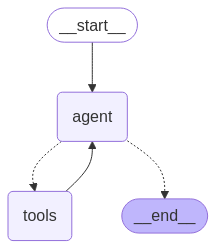

In [35]:
from langchain_core.tools import tool
from langchain.tools import Tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver


def print_stream(stream):
    """Prints to stdout the LLM's output stream"""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
            

@tool
def identify_piis(text:str) -> list[dict[str, str]]:
    """Identifies all Personal Identiable Information (PIIs) in the given context
    
    Args:
        text (str): Text where to look for PIIs
        
    Returns:
        list[dict[str, str]]: A list of all PIIs found, with each item being an object with Type and Value keys.
    """
    return parsing_chain.invoke({"content": text})


# Create a Tool instance from the functions defined earlier in the notebook
placeholders_tool = Tool.from_function(
    func=pii_to_placeholders,
    name="pii_to_placeholders",
    description="Maps each entity in the list to a placeholder based on the entity type",
)

redact_tool = Tool.from_function(
    func=fuzzy_redaction,
    name="fuzzy_redaction",
    description=(
        "Text redaction using fuzzy text replacement given a mapping of sensitive information "
        "to be replaced to its placeholders."
    ),
)

tools = [identify_piis, placeholders_tool, redact_tool]
print(f"🛠️ Tools: {[t.name for t in tools]}")

# Bind the tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Create the ReAct agent:
# We can add "chat memory" to the graph with LangGraph's checkpointer
# to retain the chat context between interactions
memory = MemorySaver()
agent = create_react_agent(
    model=llm_with_tools,
    tools=tools,
    checkpointer=memory,
    # prompt=PROMPT_TEMPLATE
)
agent

In [51]:
_text = "This is John Doe from Winskonsin"


messages = [
    SystemMessage(content=SYSTEM_PROMPT),
    HumanMessage(content=f"Redact the following text: ```{_text}```"),
]


s = llm_with_tools.invoke(messages)
print(s.content)

To redact the given text according to the provided rules, we need to identify and redact any Personal Identifiable Information (PII) and details that could identify geographical locations of parties/events.

Given text: "This is John Doe from Winskonsin"

1. **Names of Individuals**: "John Doe" is a name that should be redacted as it identifies an individual.
2. **Geographical Location**: "Winskonsin" appears to be a misspelling of "Wisconsin," which is a state in the United States. This geographical location should be redacted if it could be used to identify the location of a party or event.

Redacted text: "This is [REDACTED] from [REDACTED]"


In [40]:
from langchain_core.messages import HumanMessage, SystemMessage


config = {
    "configurable": {"thread_id": "redaction-123"}
}  # The thread ID is what will give us memory

messages = [
    SystemMessage(
        content=(
            "You are a helpful assistant tasked with identifying Personal Identifiable Information and then redacting "
            "a given piece of text. "
            "You have several tools at your disposal to identify and replace sensitive extract information. "
            "Following this sequence:\n"
            "1. identify PIIs - tool 'identify_piis'\n"
            "2. create placeholders for the found PIIs and finally - tool 'pii_to_placeholders'\n"
            "3. redact the original text - tool 'fuzzy_redaction'\n"
        )
    ),
    HumanMessage(
        content=f"Redact the following text: ```{text}```"
    ),
]

print_stream(agent.stream({"messages": messages}, config=config, stream_mode="values"))

================================ Human Message =================================

Redact the following text: ```#### **MASTER LICENSE AGREEMENT**

**Between Customer and Supply Chain Consultants, Inc. d/b/a Arkieva Linden Green Center 5460 Fairmont Drive Wilmington, DE 19808 Telephone: 302-738-9215 Fed ID/TIN: 51-035 0007**

Customer Name: BUCKMAN LABORATORIES INTERNATIONAL, INC.

Address: 1256 North McLean Boulevard, Memphis Tennessee 38108-1241, U.S.A. Telephone: (901) 278-0330

ATTN:

| 1.0  | DEFINITIONS<br>3             |
|------|------------------------------|
| 2.0  | LICENSE3                     |
| 3.0  | USE3                         |
| 4.0  | PAYMENT<br>4                 |
| 5.0  | SOFTWARE MAINTENANCE4        |
| 6.0  | WARRANTIES AND REMEDIES<br>4 |
| 7.0  | INDEMNITY5                   |
| 8.0  | LIMITATION OF LIABILITY5     |
| 9.0  | OWNERSHIP6                   |
| 10.0 | TERMINATION OF DISTRIBUTOR6  |
| 11.0 | CONFIDENTIALITY<br>6         |
| 12.0 | TERMINATION7      